In [1]:
import torch.nn          as nn
import torch.optim       as optim
import numpy             as np
import matplotlib.pyplot as plt
import torch

from libraries.graph      import POSCAR_graph_encoding, graph_POSCAR_encoding
from os                   import path, listdir
from torch.utils.data     import random_split
from torch_geometric.data import Data
from pymatgen.core        import Structure

import sys
sys.path.append('../')
import MP.MP_library as MPL

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Machine-learning parameters
n_epochs      = 1000
batch_size    = 128
learning_rate = 0.0001

# Number of diffusing and denoising steps
n_t_steps = 10

# Decay of parameter alpha
noise_contribution = 0.15
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.2
dropout_edge = 0.2

# Graph embedding

In [3]:
import numpy as np
from scipy.optimize import minimize
import numpy               as np
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch.nn            as nn
import networkx            as nx
import torch
import sys
import itertools

from pymatgen.core.structure       import Structure
from scipy.spatial                 import Voronoi
from torch.nn                      import Linear
from torch_geometric.nn            import GCNConv, GraphConv

In [4]:
temp_structure = Structure.from_file('POSCAR')

#nodes, edges, attributes = graph_POSCAR_encoding(temp_structure)

# Construct temporal graph structure
#graph = Data(x=nodes,
#             edge_index=edges,
#             edge_attr=attributes
#            )

cell = np.array([
        [12.6, 0, 0],
        [0, 17.2, 0],
        [0, 0, 10.3]
    ])

n_atoms =  temp_structure.num_sites

#POSCAR_graph_encoding(graph, cell, file_name=f'CONTCAR', POSCAR_directory='./')
#graph

In [5]:
# Map all sites to the unit cell; 0 ≤ xyz < 1
structure = Structure.from_sites(temp_structure, to_unit_cell=True)

# Get Voronoi nodes in primitive structure and then map back to the
# supercell
prim_structure = structure.get_primitive_structure()

# Get all atom coords in a supercell of the structure because
# Voronoi polyhedra can extend beyond the standard unit cell
coords = []
cell_range = list(range(-1, 2))
for shift in itertools.product(cell_range, cell_range, cell_range):
    for site in prim_structure.sites:
        shifted = site.frac_coords + shift
        coords.append(prim_structure.lattice.get_cartesian_coords(shifted))

# Voronoi tessellation
voro = Voronoi(coords)

tol = 1e-6
new_ridge_points = []
for atoms in voro.ridge_points:  # Atoms are indexes referred to coords
    # Dictionary for storing information about each atom
    atoms_info = {}

    new_atoms = []
    # Check if any of those atoms belong to the unitcell
    for atom_idx in range(2):
        atom = atoms[atom_idx]

        # Direct ccordinates from supercell referenced to the primitive cell
        frac_coords = prim_structure.lattice.get_fractional_coords(coords[atom])

        is_atom_inside = True
        frac_coords_uc = frac_coords
        if not np.all([-tol <= coord < 1 + tol for coord in frac_coords]):
            # atom_x is not inside
            is_atom_inside = False

            # Apply periodic bounday conditions
            while np.any(frac_coords_uc > 1): frac_coords_uc[np.where(frac_coords_uc > 1)] -= 1
            while np.any(frac_coords_uc < 0): frac_coords_uc[np.where(frac_coords_uc < 0)] += 1

        # Obtain mapping to index in unit cell
        uc_idx = np.argmin(np.linalg.norm(prim_structure.frac_coords - frac_coords_uc, axis=1))
        
        if is_atom_inside:
            new_atoms.append(str(uc_idx))
        else:
            new_atoms.append('-'+str(uc_idx))
    
    distance = np.linalg.norm(coords[atoms[1]] - coords[atoms[0]])
    new_atoms.append(distance)
    new_atoms.append(atoms[0])
    new_atoms.append(atoms[1])
    
    new_ridge_points.append(new_atoms)
new_ridge_points = np.array(new_ridge_points)

In [6]:
len(voro.ridge_points), len(new_ridge_points)

(13321, 13321)

In [7]:
# Delete those edges which only contain images
to_delete = []
for k in range(len(new_ridge_points)):
    pair = new_ridge_points[k, :2]
    if (pair[0][0] == '-') and (pair[1][0] == '-'):
        to_delete.append(k)
new_ridge_points = np.delete(new_ridge_points, to_delete, axis=0)

In [8]:
len(new_ridge_points)

694

In [9]:
edges      = []
attributes = []
for idx_i in range(n_atoms):
    for idx_j in np.arange(idx_i+1, n_atoms):
        to_delete = []
        for k in range(len(new_ridge_points)):
            pair = new_ridge_points[k, :2]
            dist = new_ridge_points[k, 2]
            
            if np.any(pair == str(idx_i)):  # Real for idx_i
                if pair[0][0] == '-': pair[0] = pair[0][1:]
                if pair[1][0] == '-': pair[1] = pair[1][1:]
                
                if np.any(pair == str(idx_j)):  # Real or image for idx_j
                    edges.append(np.array(pair, dtype=int))
                    attributes.append(float(dist))
                    to_delete.append(k)

        # Delete these added edges, which are no longed needed
        new_ridge_points = np.delete(new_ridge_points, to_delete, axis=0)

edges      = np.array(edges)
attributes = np.array(attributes)

In [10]:
len(edges), len(new_ridge_points)

(503, 191)

In [11]:
aaaa = edges.copy()
a = 0
for i in range(len(aaaa)):
    for j in np.arange(i+1, len(aaaa)):
        if np.all(aaaa[i] == aaaa[j]) or np.all(aaaa[i] == aaaa[j][::-1]):
            a +=1
            print(aaaa[i], aaaa[j])

In [12]:
np.savetxt('aa.txt', edges)

In [13]:
def update_n_connected_dict(n_connected_dict, idx_0, edge_indexes, edge_attributes):
    for i in np.arange(3+1)[::-1]:  # i = {3, 2, 1, 0}
        for idx_t in n_connected_dict[i]:
            if get_distance_attribute(idx_0, idx_t, edge_indexes, edge_attributes) is not None:
                # Remove from current list
                n_connected_dict[i].remove(idx_t)
                
                if i < 3:  # Else there is no list
                    # Append to next list
                    n_connected_dict[i+1].append(idx_t)
    return n_connected_dict


def get_n_connected(idx_0, cartesian_positions, edge_indexes, edge_attributes):
    n_connected = 0
    idx_connected = []
    for idx_t in list(cartesian_positions.keys()):
        if get_distance_attribute(idx_0, idx_t, edge_indexes, edge_attributes) is not None:
            n_connected += 1
            idx_connected.append(idx_t)
    
    return n_connected, idx_connected

def allocate_atom_n(d_01, x2, y2, d_0n, d_1n, d_2n):
    """Calculate the coordinates of atom 'n' based on geometric constraints.

    Args:
        d_01 (float): Distance between atoms '0' and '1'.
        x2   (float): x-coordinate of atom '2'.
        y2   (float): y-coordinate of atom '2'.
        d_0n (float): Distance between atoms '0' and 'n'.
        d_1n (float): Distance between atoms '1' and 'n'.
        d_2n (float): Distance between atoms '2' and 'n'.

    Returns:
        list: A list containing the x, y, and z coordinates of atom 'n'.
    """
    
    # Calculate x-coordinate of atom 'n'
    xn = (d_01**2 + d_0n**2 - d_1n**2) / (2 * d_01)
    
    # Calculate y-coordinate of atom 'n'
    yn = (d_1n**2 - d_2n**2 - d_01**2 + 2 * xn * d_01 + x2**2 - 2 * xn * x2 + y2**2) / (2 * y2)
    
    # Calculate z-coordinate of atom 'n'
    zn_square = d_0n**2 - xn**2 - yn**2
    if zn_square > -1e-4:  # Accounting for numerical errors
        zn = np.sqrt(zn_square)
        return [xn, yn, zn]
    return None


def get_distance_attribute(index0, index1, edge_indexes, edge_attributes):
    """Get the distance attribute between two nodes with given indices.

    Args:
        index0          (int):        Index of the first node.
        index1          (int):        Index of the second node.
        edge_indexes    (np.ndarray): Array containing indices of connected nodes for each edge.
        edge_attributes (np.ndarray): Array containing attributes corresponding to each edge.

    Returns:
        float: The distance attribute between the two nodes.
        False if index0, index1 not linked.
    """
    
    # Create a mask to find matching edges
    mask_direct  = (edge_indexes[0] == index0) & (edge_indexes[1] == index1)
    mask_reverse = (edge_indexes[0] == index1) & (edge_indexes[1] == index0)
    
    # Check if any edge satisfies the conditions
    matching_edge_indices = np.where(mask_direct | mask_reverse)[0]
    
    if len(matching_edge_indices) == 0:
        return None  # The pair is not linked
    
    # Get the distance attribute from the first matching edge
    distance_attribute = edge_attributes[matching_edge_indices[0]]
    
    return distance_attribute


def find_initial_basis(total_particles, edge_indexes, edge_attributes):
    for idx_0 in range(total_particles):
        for idx_1 in np.arange(idx_0+1, total_particles):
            for idx_2 in np.arange(idx_1+1, total_particles):
                condition_01 = (get_distance_attribute(idx_0, idx_1, edge_indexes, edge_attributes) is not None)
                condition_12 = (get_distance_attribute(idx_1, idx_2, edge_indexes, edge_attributes) is not None)
                condition_02 = (get_distance_attribute(idx_0, idx_2, edge_indexes, edge_attributes) is not None)
                if condition_01 and condition_12 and condition_02:
                    return idx_0, idx_1, idx_2


def find_valid_reference(n_connected, idx_connected, edge_indexes, edge_attributes):
    for i in range(n_connected):
        for j in np.arange(i+1, n_connected):
            for k in np.arange(j+1, n_connected):
                idx_0 = idx_connected[i]
                idx_1 = idx_connected[j]
                idx_2 = idx_connected[k]

                x2, y2, _ = cartesian_positions[idx_2]
                
                # Get necessary distances
                d_01 = get_distance_attribute(idx_0, idx_1, edge_indexes, edge_attributes)
                d_0n = get_distance_attribute(idx_0, idx,   edge_indexes, edge_attributes)
                d_1n = get_distance_attribute(idx_1, idx,   edge_indexes, edge_attributes)
                d_2n = get_distance_attribute(idx_2, idx,   edge_indexes, edge_attributes)
                
                temp_position = allocate_atom_n(d_01, x2, y2, d_0n, d_1n, d_2n)
                
                if temp_position is not None:
                    return temp_position

In [21]:
# Extract indexes and attributes from the graph
edge_indexes    = edges.T.copy()
edge_attributes = attributes.copy()

# Define the number of atoms in the graph
total_particles = n_atoms



# Select three initial particles which are interconnected
idx_0, idx_1, idx_2 = find_initial_basis(total_particles, edge_indexes, edge_attributes)

# Get necessary distances
d_01 = get_distance_attribute(idx_0, idx_1, edge_indexes, edge_attributes)
d_02 = get_distance_attribute(idx_0, idx_2, edge_indexes, edge_attributes)
d_12 = get_distance_attribute(idx_1, idx_2, edge_indexes, edge_attributes)

# Reference the first three atoms
x2 = (d_01**2 + d_02**2 - d_12**2) / (2 * d_01)
y2 = np.sqrt(d_02**2 - x2**2)

# Impose three particles at the beginning
cartesian_positions = {
    idx_0: [0,    0,  0],
    idx_1: [d_01, 0,  0],
    idx_2: [x2,   y2, 0]
}

all_idxs = np.delete(np.arange(total_particles),
                     [idx_0, idx_1, idx_2])

highest_n_explored = np.min(all_idxs)

# Initialized to 3 for three connections
n_connected_dict = {
    0: [],
    1: [],
    2: [],
    3: [highest_n_explored]
}

In [41]:
edges

array([[ 2,  0],
       [ 0,  4],
       [24,  0],
       ...,
       [66, 70],
       [67, 69],
       [68, 70]])

In [52]:
idx = 0
edges[np.where(edges[:, 0] == idx)], edges[np.where(edges[:, 1] == idx)]

(array([[ 0,  4],
        [ 0, 28],
        [ 0, 42],
        [ 0, 57],
        [ 0, 59],
        [ 0, 69]]),
 array([[ 2,  0],
        [24,  0],
        [30,  0],
        [53,  0],
        [65,  0]]))

In [53]:
idx = 2
edges[np.where(edges[:, 0] == idx)], edges[np.where(edges[:, 1] == idx)]

(array([[ 2,  0],
        [ 2,  4],
        [ 2, 24],
        [ 2, 32],
        [ 2, 53],
        [ 2, 55],
        [ 2, 67]]),
 array([[26,  2],
        [44,  2],
        [49,  2],
        [61,  2],
        [65,  2]]))

In [54]:
idx = 4
edges[np.where(edges[:, 0] == idx)], edges[np.where(edges[:, 1] == idx)]

(array([[ 4, 28],
        [ 4, 34],
        [ 4, 46],
        [ 4, 55],
        [ 4, 57],
        [ 4, 63],
        [ 4, 67],
        [ 4, 69]]),
 array([[ 0,  4],
        [ 2,  4],
        [26,  4]]))

array([[ 0,  4],
       [ 2,  4],
       [26,  4]])

In [39]:
for idx_i in range(n_atoms):
    for idx_j in np.arange(idx_i+1, n_atoms):
        for idx_k in np.arange(idx_j+1, n_atoms):
            cartesian_positions = {
                idx_0: [0,    0,  0],
                idx_1: [d_01, 0,  0],
                idx_2: [x2,   y2, 0]
            }
            
            all_idxs = np.delete(np.arange(total_particles),
                     [idx_0, idx_1, idx_2])
            
            for idx in all_idxs:
                a, _ = get_n_connected(idx, cartesian_positions, edge_indexes, edge_attributes)
                if a > 3:
                    print(a)

KeyboardInterrupt: 

In [18]:
idx_0, idx_1, idx_2

(0, 2, 4)

In [19]:
highest_n_explored

1

In [20]:
get_n_connected(idx_1, cartesian_positions, edge_indexes, edge_attributes)

(2, [0, 4])

In [22]:
n_connected_dict

{0: [], 1: [], 2: [], 3: [1]}

In [24]:
get_n_connected(1, cartesian_positions, edge_indexes, edge_attributes)

(0, [])

In [26]:
while True:  # Goes until all particles have been studied
    # Using a first-one-first-out approach
    idx = n_connected_dict[3][0]

    # Updated highest_n_explored with idx
    if idx > highest_n_explored:  # This allows tracking all particles
        highest_n_explored = idx

    n_connected, idx_connected = get_n_connected(idx, cartesian_positions, edge_indexes, edge_attributes)
    print(idx, n_connected, idx_connected)
    # Set idx in cartesian_positions or else add it to n_connected_dict
    if n_connected >= 3:
        # Extract the cartesian coordinates of idx
        temp_position = find_valid_reference(n_connected, idx_connected, edge_indexes, edge_attributes)

        # Check if there are enough particles able to locate idx (images make this step more difficult
        if temp_position is not None:
            # Generate temporal dictionary with the cartesian coordinates
            temp_dict = {
                idx: temp_position
            }

            # Update general dictionary with cartesian coordinates
            cartesian_positions.update(temp_dict)

            # Now that cartesian_positions has been increased, n_connected_dict is updated
            n_connected_dict = update_n_connected_dict(n_connected_dict, idx, edge_indexes, edge_attributes)
        else:
            # Make idx wait for new connections to appear
            n_connected_dict[2].append(idx)

        # Remove idx from 3_connected_dict
        n_connected_dict[3].remove(idx)
    else:
        # n_connected_dict is updated adding idx where it belongs to
        n_connected_dict[n_connected].append(idx)

    # Check if all partciles have been already explored
    if highest_n_explored == total_particles:
        break

    # If not, if 3_connected_dict is finished, we add a new particle to be explored
    if not len(n_connected_dict[3]):
        n_connected_dict[3].append(highest_n_explored)

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []

1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []
1 0 []


KeyboardInterrupt: 

# Diffusion

In [3]:
graph = GML.get_random_graph(5, 1)

graph.x         = torch.abs(graph.x)
graph.edge_attr = torch.abs(graph.edge_attr)

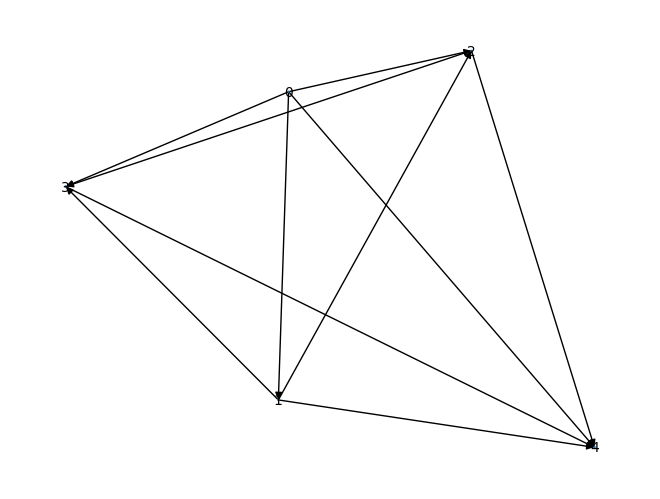

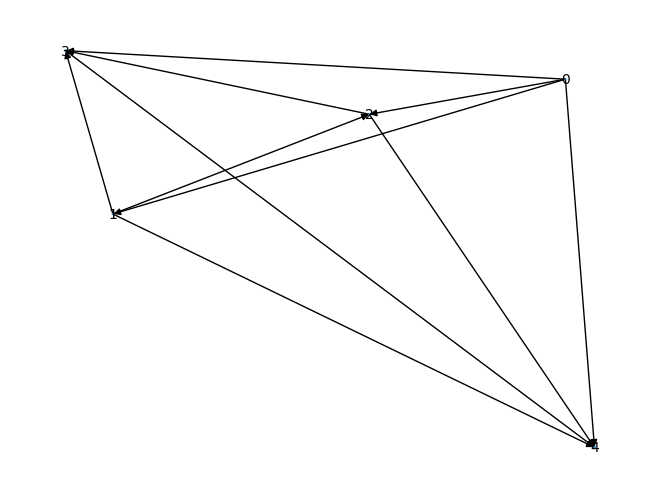

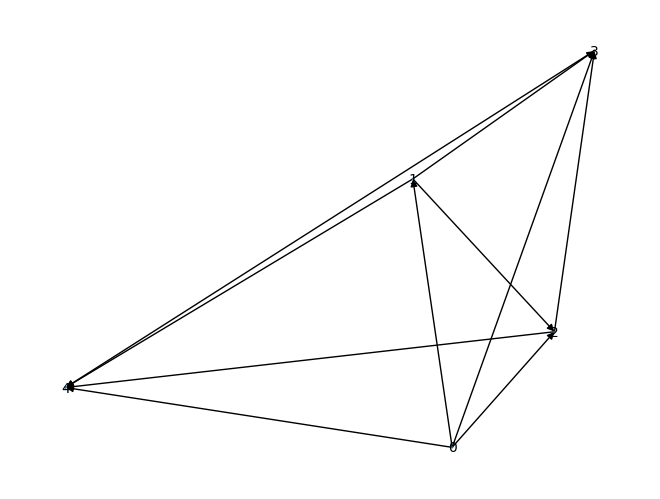

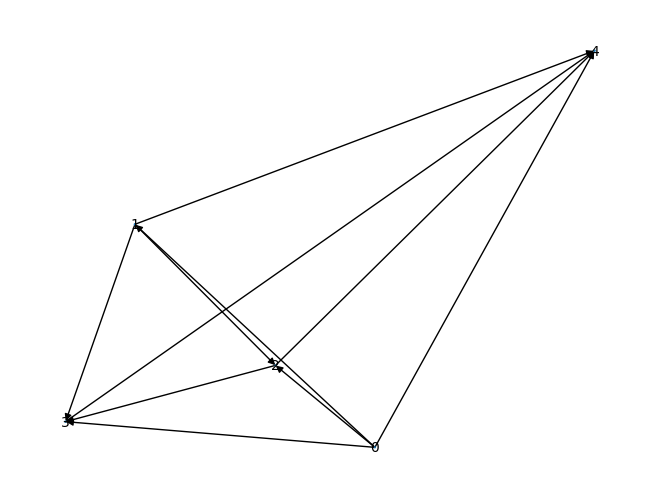

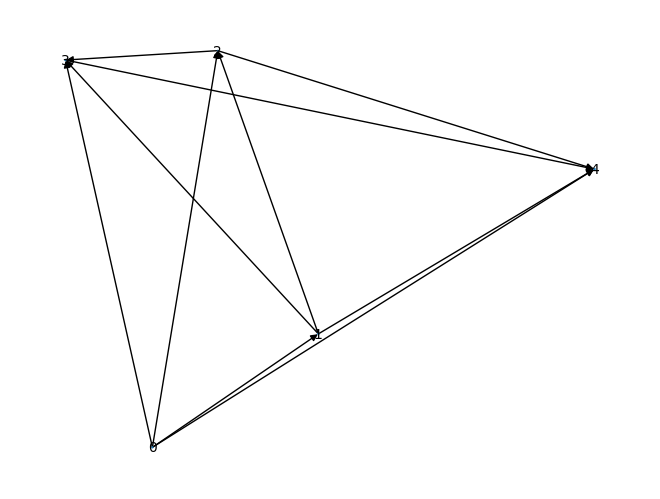

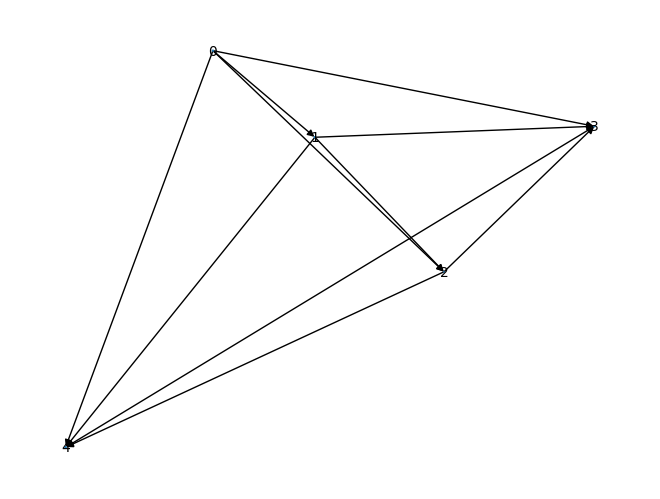

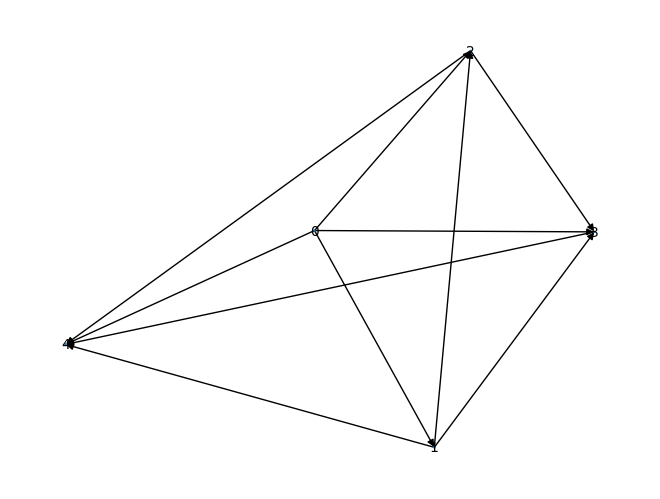

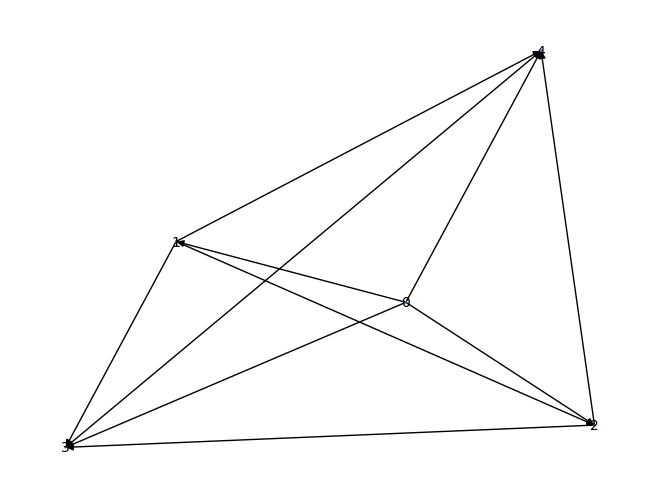

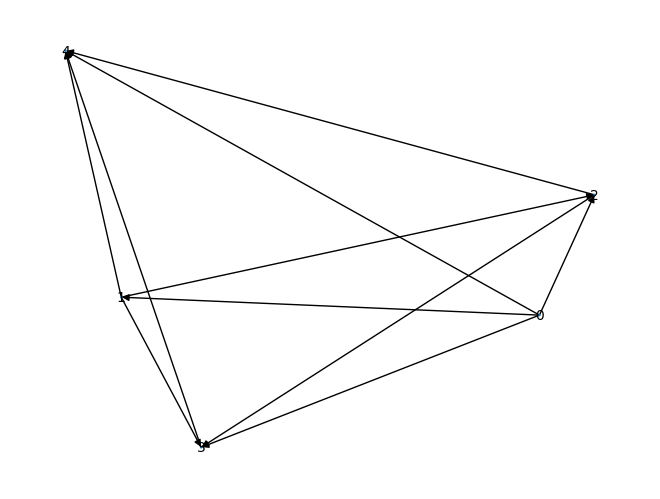

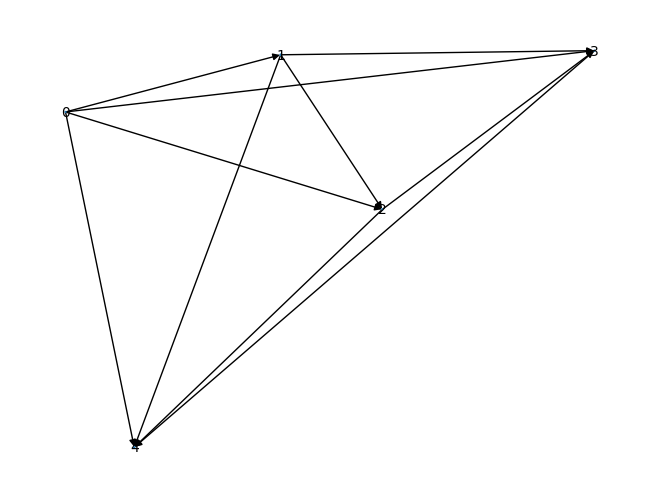

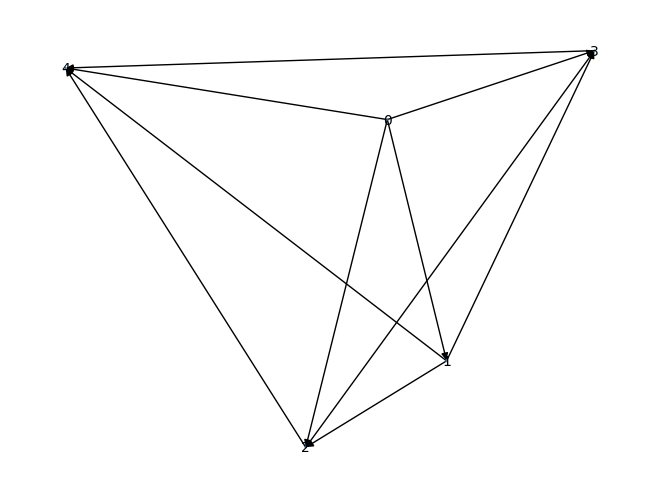

In [5]:
diffused_graph, all_graphs = GML.diffuse(graph, n_t_steps,
                                         s=alpha_decay, plot_steps=True)

In [6]:
# Extract features and attributes from each graph
all_xs    = []
all_attrs = []
for graph in all_graphs:
    all_xs.append(graph.x)
    all_attrs.append(graph.edge_attr)

# Each row corresponds to a different feature/edge
all_xs_concat    = torch.hstack(all_xs)
all_attrs_concat = torch.vstack(all_attrs).T

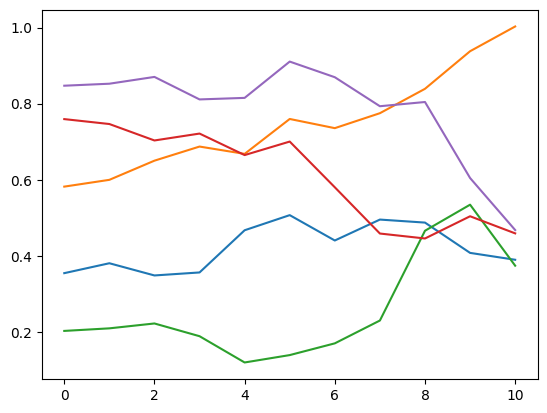

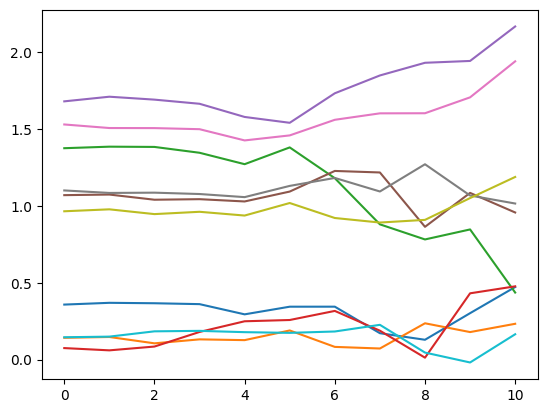

In [7]:
# Plot the evolution of features
for feature in all_xs_concat:
    feature_evolution = feature.detach().cpu().numpy()
    plt.plot(feature_evolution)
plt.show()

# Plot the evolution of edge attributes
for attribute in all_attrs_concat:
    attribute_evolution = attribute.detach().cpu().numpy()
    plt.plot(attribute_evolution)
plt.show()

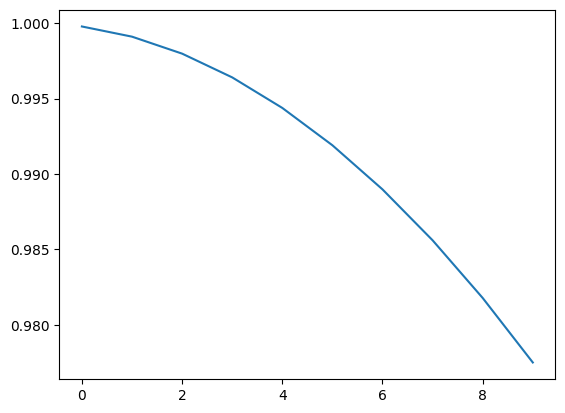

In [8]:
# Plot alpha_t parameter
alphas = GML.get_alpha_t(np.arange(1, n_t_steps+1), n_t_steps, s=alpha_decay)
plt.plot(alphas)